PUXANDO OS DADOS PARA O PAIR TRADE

In [232]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from bcb import sgs



In [233]:
ativos = ["BTC-USD","ETH-USD"]

In [234]:
df = yf.download(ativos, start="2017-11-09")["Adj Close"]

[*********************100%***********************]  2 of 2 completed


In [235]:
cdi = sgs.get({'CDI':12}, start='2005-01-01')

In [236]:
df["cdi"] = cdi/100

In [237]:
df["ratio"] = df["BTC-USD"]/df["ETH-USD"]

In [238]:
std = df["ratio"].std()

In [239]:
df["ratio average"] = df["ratio"].rolling(50).mean()
df["ratio +std"] = df["ratio average"] + std/3
df["ratio -std"] = df["ratio average"] -std/3

In [240]:
df = df.dropna()

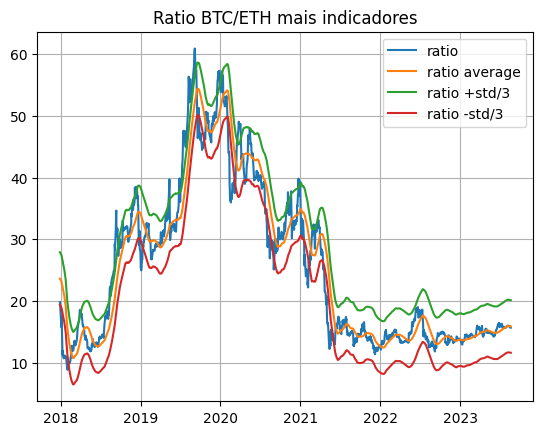

In [241]:
plt.plot(df.index, df["ratio"], label="ratio")
plt.plot(df.index, df["ratio average"], label="ratio average")
plt.plot(df.index, df["ratio +std"], label="ratio +std/3")
plt.plot(df.index, df["ratio -std"], label="ratio -std/3")
plt.title("Ratio BTC/ETH mais indicadores")
plt.legend()
plt.grid()


In [242]:
number_of_orders = 0
sinal_pair_trade = list([])
for i in range(len(df)):
    if (df["ratio"].iloc[i] > df["ratio +std"].iloc[i]):
        sinal_pair_trade.append(1)
        number_of_orders=1
        print("compra eth")
    elif (df["ratio"].iloc[i] < df["ratio -std"].iloc[i]):
        sinal_pair_trade.append(2)
        number_of_orders=2
        print("compra btc")
    elif(df["ratio"].iloc[i-1] > df["ratio average"].iloc[i])&(df["ratio"].iloc[i] < df["ratio average"].iloc[i]):
        sinal_pair_trade.append(-1)  
        print("vende ultima posição eth") 
    elif(df["ratio"].iloc[i-1] < df["ratio average"].iloc[i])&(df["ratio"].iloc[i] > df["ratio average"].iloc[i]):
        sinal_pair_trade.append(-2)  
        print("vende ultima posição btc")       
    else:
        sinal_pair_trade.append(0)
        print(0)

sinal_pair_trade = pd.DataFrame(sinal_pair_trade)
sinal_pair_trade.value_counts()

0
0
compra btc
compra btc
compra btc
compra btc
compra btc
compra btc
compra btc
compra btc
compra btc
compra btc
compra btc
compra btc
compra btc
compra btc
compra btc
compra btc
compra btc
compra btc
compra btc
compra btc
compra btc
compra btc
compra btc
compra btc
0
0
0
0
0
0
0
0
vende ultima posição btc
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
compra eth
compra eth
compra eth
compra eth
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
vende ultima posição btc
vende ultima posição eth
0
0
0
0
0
0
0
vende ultima posição btc
0
0
0
0
0
vende ultima posição eth
vende ultima posição btc
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
compra eth
compra eth
compra eth
compra eth
0
compra eth
compra eth
compra eth
compra eth
compra eth
compra eth
compra eth
compra eth
compra eth
compra eth
compra eth
compra eth
compra eth
compra eth
compra eth
compra eth
compra eth
compra eth
compra eth
compra eth
compra eth
compra eth
compra eth

 0    1042
 2     156
 1     130
-2      47
-1      43
dtype: int64

In [243]:
df["sinal_pair_trade"] = sinal_pair_trade.values


In [244]:
ultimo_valor = None

for i in range(len(df)):
    if(df["sinal_pair_trade"].iloc[i] != 0):#&(df["sinal_pair_trade"].iloc[i] != 1)&(df["sinal_pair_trade"].iloc[i] != 2):
        ultimo_valor = df["sinal_pair_trade"].iloc[i]
    elif(df["sinal_pair_trade"].iloc[i] == 0):
        df["sinal_pair_trade"].iloc[i] = ultimo_valor 

c:\Python37\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [245]:
for i in range(len(df)):
    if (df["sinal_pair_trade"].iloc[i] == -1)or(df["sinal_pair_trade"].iloc[i] == -2):
        df["sinal_pair_trade"].iloc[i] = 0

In [246]:
df["sinal_pair_trade"] = df["sinal_pair_trade"].fillna(0)

In [247]:
df["pct_change_eth"] = df["ETH-USD"].pct_change()
df["pct_change_btc"] = df["BTC-USD"].pct_change()


In [248]:
vetor_rent = list([])
for i in range(len(df)):
    if (df["sinal_pair_trade"].iloc[i-1] == 1):
        vetor_rent.append(df["pct_change_eth"].iloc[i])

    elif (df["sinal_pair_trade"].iloc[i-1] == 2):
        vetor_rent.append((df["pct_change_btc"].iloc[i]))

    elif (df["sinal_pair_trade"].iloc[i-1] == 0):
        vetor_rent.append(df["cdi"].iloc[i])   

In [249]:
df["rentpair"] = vetor_rent

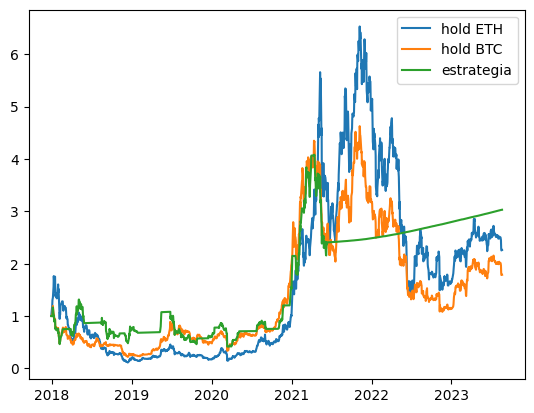

In [250]:
plt.plot(df.index, (df["pct_change_eth"]+1).cumprod(), label="hold ETH")
plt.plot(df.index, (df["pct_change_btc"]+1).cumprod(), label="hold BTC")
plt.plot(df.index, (df["rentpair"]+1).cumprod(), label="estrategia")

plt.legend()


In [251]:
df = df.dropna()

In [252]:
import statsmodels.api as sm

Y = sm.add_constant(df["pct_change_btc"])
modelo = sm.OLS(df["rentpair"], Y).fit()
alfa, beta = modelo.params

print("Beta:", beta)
print("Alfa:", alfa)

Beta: 0.48953606500368335
Alfa: 0.0007808349716475115


TESTE DE COINTEGRAÇÃO

In [253]:
from statsmodels.tsa.stattools import coint

In [254]:
result = coint(df['pct_change_btc'], df['pct_change_eth'])


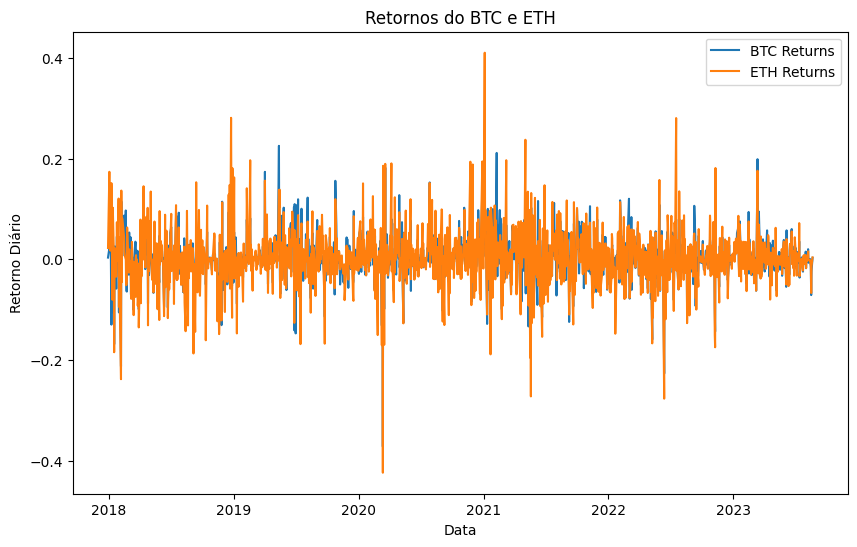

In [255]:
# Plotar os retornos do BTC e ETH
plt.figure(figsize=(10, 6))
plt.plot(df['pct_change_btc'], label='BTC Returns')
plt.plot(df['pct_change_eth'], label='ETH Returns')
plt.legend()
plt.title("Retornos do BTC e ETH")
plt.xlabel("Data")
plt.ylabel("Retorno Diário")
plt.show()

In [256]:

# Imprimir os resultados
print("Teste de Cointegração:")
print("Estatística de teste:", result[0])
print("P-valor:", result[1])
print("Valores críticos:", result[2])

Teste de Cointegração:
Estatística de teste: -14.553494269556742
P-valor: 4.376768547081452e-26
Valores críticos: [-3.90419111 -3.34044845 -3.04744655]
